# Cartpole: exercise
This my attempt to solve [OpenAI. Requests for Research. Cartpole: for newcomers to RL](https://openai.com/requests-for-research/#cartpole).

_No educational/publicistic value is intended, made exclusively for self docmenting and writing exercise.
Nevertheless any feedback is welcome._

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
env = gym.make('CartPole-v0')

SEED = 42
env.seed(SEED)
np.random.seed(SEED)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


> Start with a simple linear model (that has only four parameters), and use the sign of the weighted sum to choose between the two actions.

In [3]:
def make_linear_model(weights):
    def policy(state):
        weighted_sum = np.dot(state, weights)
        return 0 if weighted_sum < 0 else 1
    return policy

In [4]:
def evaluate_policy(policy):
    """Runs policy through environment, returns accumulated reward."""
    score, state, done = 0, env.reset(), False
    while not done:  # CartPole-v0 uses max_episode_steps=200
        action = policy(state)
        state, reward, done, _ = env.step(action)
        score += reward
    return score

> The random guessing algorithm: generate 10,000 random configurations of the model's parameters, and pick the one that achieves the best cumulative reward. It is important to choose the distribution over the parameters correctly.

In [5]:
# Generate random weights (1000 is more than enough) with naive normal distribution.
random_weights = np.random.standard_normal([1000, 4])

# Evaluate
evaluation_scores = np.apply_along_axis(
    lambda weights: evaluate_policy(make_linear_model(weights)),
    axis=1, # apply for each row
    arr=random_weights)

print("Best score:", evaluation_scores.max(),
      " best random weights: ", random_weights[evaluation_scores.argmax()])

Best score: 200.0  best random weights:  [-0.676922    0.61167629  1.03099952  0.93128012]


Turns out one can "solve" cartpool with just a handful of random weights.

> The hill-climbing algorithm: start with a random setting of the parameters, add a small amount of noise to the parameters, and evaluate the new parameter configuration. If it performs better than the old configuration, discard the old configuration and accept the new one. Repeat this process for some number of iterations. How long does it take to achieve perfect performance?

Best score: 200.0  best weights:  [-0.48271142  0.17168059  0.47158941  0.76685094]


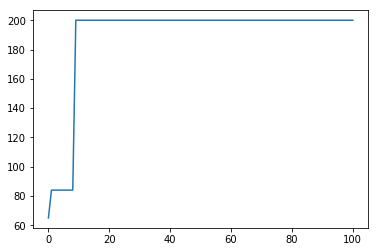

In [6]:
climbing_iterations, noise_amplitude = 100, 0.5

weights = np.random.standard_normal([4])
score = evaluate_policy(make_linear_model(weights))
score_hist = [score]

for T in range(climbing_iterations):
    noise = np.random.uniform(low=-noise_amplitude, high=noise_amplitude, size=4)
    n_weights = weights + noise
    n_score = evaluate_policy(make_linear_model(n_weights))
    if n_score > score:
        weights,score = n_weights, n_score
    score_hist.append(score)

plt.plot(score_hist)
print("Best score:", score, " best weights: ", weights)

> Policy gradient algorithm: here, instead of choosing the action as a deterministic function of the sign of the weighted sum, make it so that action is chosen randomly, but where the distribution over actions (of which there are two) depends on the numerical output of the inner product. Policy gradient prescribes a principled parameter update rule [
[1](https://www.youtube.com/watch?v=oPGVsoBonLM),
[2](http://www0.cs.ucl.ac.uk/staff/D.Silver/web/Teaching_files/pg.pdf)].

> Your goal is to implement this algorithm for the simple linear model, and see how long it takes to converge.

My solution is based on [Lecture 7: Policy Gradient](http://www0.cs.ucl.ac.uk/staff/D.Silver/web/Teaching_files/pg.pdf)
from awesome [UCL Course on RL](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html) by David Silver.

### Policy

We're trying to maximize objective function
$$
J(\theta)=\mathbb{E}_{\pi_\theta}[Q^{\pi_\theta}(s, a)] =
\sum_{s \in \mathcal{S} }{d(s)}\sum_{a \in \mathcal{A} }{ \pi_\theta(s, a) Q^{\pi_\theta}(s, a)}
$$
According to Policy Gradient Theorem
$$
\nabla_\theta{J(\theta)} = 
\mathbb{E}_{\pi_\theta}[\nabla_\theta\log\pi_\theta(s, a)Q^{\pi_\theta}(s,a)]
$$

Let's introduce abstract class `Policy` that represents function $\pi_\theta(s, a)$ parameterized by $\theta$, where:
- `Policy.parameters` is $\theta$;
- `Policy.probabilities(state)` returns vector $\langle \pi_\theta(s, a_1), \dots, \pi_\theta(s, a_n) \rangle$;
- `Policy.sample(state)` samples action $a$ for state $s$, according probabilities $\pi_\theta(s, a)$;
- `Policy.score(state, action)` is policy score function defined as $\nabla_\theta\log\pi_\theta(s, a)$.

In [7]:
class Policy:
    def __init__(self, parameters):
        self.parameters = np.copy(parameters)
    
    def probabilities(self, state): raise NotImplemented()
    def score(self, state, action): raise NotImplemented()
    
    def sample(self, state):
        p = self.probabilities(state)
        return np.random.choice(range(len(p)), p=p)

### Monte-Carlo policy gradient

Using $G_t$ as unbiased sample of $Q^{\pi_\theta}(s_t, a_t)$, and learning rate $\alpha$

$$
\Delta\theta = \alpha \nabla_\theta\log\pi_\theta(s, a) G_t
$$

In [8]:
def run_monte_carlo_policy_gradient_ascent(policy, num_episodes, alpha, gamma):
    """
    Takes a `policy` and performs `num_episodes` rounds of gradient ascent.
    Each round, run a full episode using `policy.sample` and collect history
    [(state, action, reward), ...].
    Compute value G using history and perform update to policy parameters.
    """
    episodes_reward = np.zeros([num_episodes])
    
    for T in tqdm(range(num_episodes)):
        # Run full episode to obtain history to run Monte-Carlo on.
        state, done, history = env.reset(), False, []
        while not done:
            action = policy.sample(state)
            next_state, reward, done, _ = env.step(action)
            history.append((state, action, reward))
            state = next_state
        
        G = 0 # sampled value
        for state, action, reward in reversed(history):
            G = reward + gamma * G
            episodes_reward[T] += reward
            # Update policy parameters
            policy.parameters += alpha * policy.score(state, action) * G
    return episodes_reward

In [9]:
def plot_value_and_running_avg(v, window=10):
    X = list(range(len(v)))
    plt.plot(X, v, X, pd.rolling_mean(v, window))

Now we need to implement a policy (`probability` and `score` methods).

### Softmax policy

David's lecture uses softmax as an example. Probabilities of actions are computed as a softmax of weights, where weight is linear combination of stat-action features and policy parameters.

$$
\pi_\theta(s, a_i) = 
\frac {exp(\phi(s, a_i)^\top \theta)} {\sum_{a \in \mathcal{A} }{exp(\phi(s, a)^\top \theta)}}
$$

The score function is

$$
\nabla_\theta\log\pi_\theta(s, a) = \phi(s, a) - \mathbb{E}_{\pi_\theta}[\phi(s, \cdot)]
$$

#### Choosing features represenation of state and action.

##### State + one-hot encoded action
As an ML-noob my first thougt was "if features convey all available information it should be fine".

So I've decided to concatenate four variables of observations with [one-hot](https://en.wikipedia.org/wiki/One-hot) encoded action:
$$\phi(s, a_i) = \langle s_1, s_2, s_3, s_4, \delta_{1i}, \delta_{2i} \rangle$$ , where $\delta_{jk}$ is [Kronecker delta](https://en.wikipedia.org/wiki/Kronecker_delta).

Turns out it was poor choise.
Gradient ascent didn't have an effect on parameters associated with state ($\theta_1, \dots, \theta_4$),
only action specific parameters ($\theta_5, \theta_6$) were updated. The policy was "blind" to the environment. The reason of such behavior is pretty simple:

$$
\nabla_\theta\log\pi_\theta(s, a_i) = 
\phi(s, a_i) - \mathbb{E}_{\pi_\theta}[\phi(s, \cdot)] = \\
\langle s_1, s_2, s_3, s_4, \delta_{1i}, \delta_{2i} \rangle -
\langle s_1, s_2, s_3, s_4, \pi_\theta(s, a_1), \pi_\theta(s, a_2) \rangle = \\
\langle 0, 0, 0, 0, \delta_{1i} - \pi_\theta(s, a_1), \delta_{2i} - \pi_\theta(s, a_2) \rangle
$$

##### Better representation: State-Action Crossing 

$$
\phi(s, a_1) = \langle s_1, s_2, s_3, s_4, 0, 0, 0, 0 \rangle \\
\phi(s, a_2) = \langle 0, 0, 0, 0, s_1, s_2, s_3, s_4  \rangle
$$

100%|██████████| 2000/2000 [00:45<00:00, 43.59it/s]


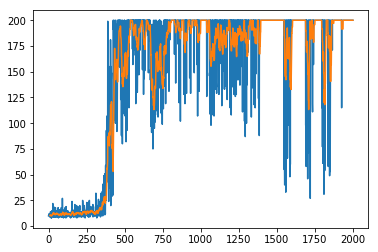

In [10]:
class StateActionCrossingSoftmaxPolicy(Policy):
    def features(self, state, action):
        if action == 0:
            return np.append(state, np.zeros([len(state)]))
        else:
            return np.append(np.zeros([len(state)]), state)
    
    def probabilities(self, state):
        e_0 = np.exp(np.dot(self.features(state, 0), self.parameters))
        e_1 = np.exp(np.dot(self.features(state, 1), self.parameters))
        norm = e_0 + e_1
        return [ e_0 / norm, e_1 / norm ]
    
    def score(self, state, action):
        p = self.probabilities(state)
        return self.features(state, action) - sum([p[a] * self.features(state, a) for a in (0, 1)])


plot_value_and_running_avg(
    run_monte_carlo_policy_gradient_ascent(
        StateActionCrossingSoftmaxPolicy(np.random.standard_normal([8])),
        num_episodes=2000, alpha=0.001, gamma=.99))

This way to represent features is equivalent to having a parameters matrix with number of rows
equal to number of state features and a column for each action.

$$
\pi_\theta(s, a_i) = \frac {e^{s^{\top}\theta_{:,i}}} {\sum_j{e^{s^{\top}\theta_{:,j}}}}
\text{ where } \theta_{:,i} \text{ is i-th column of } \theta
$$
$$
\nabla_\theta\log\pi_\theta(s, a_i) = 
\nabla_\theta{s^{\top}\theta_{:,i}} - s \langle \pi_\theta(s, a_1), \dots, \pi_\theta(s, a_n) \rangle^{\top}
$$

In other words score function looks like this:

$$
\nabla_\theta\log\pi_\theta(s, a_i)=
\begin{bmatrix}
-\pi_\theta(s, a_1)s_1 & \dots  & (1 - \pi_\theta(s, a_i))s_1 & \dots & -\pi_\theta(s, a_k)s_1 \\
-\pi_\theta(s, a_1)s_2 & \dots  & (1 - \pi_\theta(s, a_i))s_2 & \dots & -\pi_\theta(s, a_k)s_2 \\
\vdots                 & \vdots & \vdots                      & \vdots & \vdots \\
-\pi_\theta(s, a_1)s_n & \dots  & (1 - \pi_\theta(s, a_i))s_n & \dots & -\pi_\theta(s, a_k)s_n \\
\end{bmatrix}
$$

It makes code more compact:

100%|██████████| 2000/2000 [00:39<00:00, 50.74it/s]


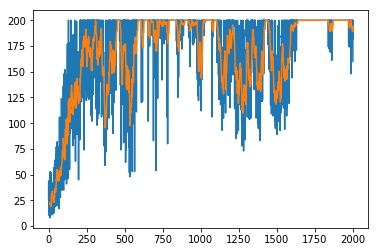

In [11]:
class MatrixSoftmaxPolicy(Policy):    
    def probabilities(self, state):
        e = np.exp(np.matmul(state, self.parameters))
        return e / e.sum()
    
    def score(self, state, action):
        s = -np.einsum('i,j->ij', state, self.probabilities(state))
        s[:,action] += state
        return s

plot_value_and_running_avg(
    run_monte_carlo_policy_gradient_ascent(
        MatrixSoftmaxPolicy(np.random.standard_normal([4, 2])),
        num_episodes=2000, alpha=0.001, gamma=.99))

#### Sigmoid policy

Essentially Cartpole policy represents probability of two disjoint outcomes: "apply force -1, otherwise apply force +1". Therefore it can be represented as $B(s)$ where
$$
\begin{cases}
\pi_\theta(s, 0)=B(s) \\
\pi_\theta(s, 1)=1-B(s)
\end{cases}
$$

Using softmax and trying to fit eight parameters appears to me as an overcomplicated way to solve binominal regression.
Let's try to solve it using sigmoid of linear combination of parameters and state only.

$$
\pi_\theta(s, a) =
\begin{cases}
\ \frac {e^{s^\top \theta}} {1 + e^{s^\top \theta}} \text{ if } a=0,  \\
\ 1 - \pi_\theta(s, 0) \text{ if } a=1.
\end{cases}
$$

It got prety nice score functuion:

$$
\nabla_\theta\log\pi_\theta(s,0) = 
\nabla_\theta \log\frac {e^{s^\top \theta}} {1 + e^{s^\top\theta}} = \\
\nabla_\theta(s^\top\theta - \log(1 + e^{s^\top\theta})) =
s - \frac {\nabla_\theta(1 + e^{s^\top\theta})} {1 + e^{s^\top\theta}} = \\
s - s \frac {e^{s^\top\theta}} {1 + e^{s^\top\theta}} = 
s(1 - \pi_\theta(s, 0)) = s\pi_\theta(s, 1)
$$

$$
\nabla_\theta\log\pi_\theta(s,1) = 
\nabla_\theta\log\frac {1} {1 + e^{s^\top\theta}} =
-\nabla_\theta\log(1 + e^{s^\top\theta})=-s\pi_\theta(s,0)
$$
Hope I got it right.


100%|██████████| 2000/2000 [00:26<00:00, 76.30it/s]


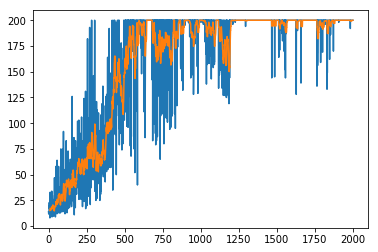

In [12]:
class SigmoidPolicy(Policy):
    def probabilities(self, state):
        z = np.dot(self.parameters, state)
        e_z = np.exp(z)
        p_0 = e_z / (1 + e_z)
        return [p_0, 1.0 - p_0]
    
    def score(self, state, action):
        p = self.probabilities(state)
        if action == 0:
            return p[1] * state
        else:
            return -p[0] * state

plot_value_and_running_avg(
    run_monte_carlo_policy_gradient_ascent(
        SigmoidPolicy(np.random.standard_normal([4])),
        num_episodes=2000, alpha=0.001, gamma=.99))

It seems to work.

### Non-linear policy with Tensorflow

100%|██████████| 1000/1000 [00:46<00:00, 21.45it/s]


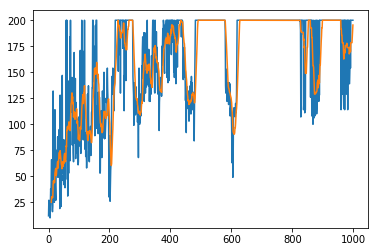

In [13]:
import tensorflow as tf

def fully_connected(inp, ouptut_size, activation='relu'):
    """Auxiliary function. Creates a fully connected layer."""
    inp_size = inp.get_shape().as_list()[-1]
    w = tf.Variable(tf.random_normal([inp_size, ouptut_size], stddev=0.35), name='W')
    tf.summary.histogram('W', w)
    b = tf.Variable(tf.zeros([ouptut_size]), name='b')
    tf.summary.histogram('b', b)
    res = tf.matmul(inp, w) + b
    if activation == 'relu':
        return tf.nn.relu(res)
    assert activation is None
    return res
    
def choose_one(A, index, name="choose_one"):
    """Auxiliary function. Returns vector C, where C[i] = A[i, index[i]]"""
    rows,cols = tf.shape(A)[0], tf.shape(A)[1] 
    flat_indx = tf.range(0, rows) * cols + index
    return tf.gather(tf.reshape(A, [-1]), flat_indx)

class Actor:
    def __init__(self, n_obs=None, n_act=None, n_hidden=None, alpha=None):
        self.observations = tf.placeholder(tf.float32, shape=[None, n_obs])

        fc1 = fully_connected(self.observations, n_hidden, activation='relu')
        fc2 = fully_connected(fc1, n_act, activation=None)
        # Probabilities of actions
        probabilities = tf.nn.softmax(fc2)
        log_p = tf.log(probabilities)
        # Pick one action
        self.sample = tf.squeeze(tf.multinomial(log_p, 1), axis=[-1])

        # Training
        self.taken_actions = tf.placeholder(tf.int32, shape=[None])
        self.advantages = tf.placeholder(tf.float32, shape=[None])

        taken_p = choose_one(log_p, self.taken_actions)
        loss = -tf.reduce_sum(taken_p * self.advantages, name="loss")
        self.train_step = tf.train.RMSPropOptimizer(learning_rate=alpha).minimize(loss)
            
def run_tf_policy_gradient(env, num_episodes, n_hidden=None, alpha=None, gamma=None):
    n_obs, n_act = np.product(env.observation_space.shape), env.action_space.n
    episode_rewards = np.zeros([num_episodes])
    
    tf.reset_default_graph()
    
    with tf.Session() as sess:
        actor = Actor(n_obs=n_obs, n_act=n_act, alpha=alpha, n_hidden=n_hidden)
        sess.run(tf.global_variables_initializer())
        
        for T in tqdm(range(num_episodes)):
            # Use Monte-Carlo method to sample state-action values.
            obs, done, history = env.reset(), False, []
            while not done:
                action = sess.run(actor.sample, feed_dict={actor.observations: [obs]})[0]
                next_obs, reward, done, _ = env.step(action)
                history.append((obs, action, reward))
                obs = next_obs
            
            observations = np.zeros([len(history), n_obs])
            actions = np.zeros([len(history)])
            values = np.zeros([len(history)])
            G = 0
            for i, (obs, action, reward) in enumerate(reversed(history)):
                episode_rewards[T] += reward
                G = G * gamma + reward
                observations[i, :], actions[i], values[i] = obs, action, G
            
            # Fit policy
            sess.run(actor.train_step, feed_dict={
                actor.observations: observations,
                actor.taken_actions: actions,
                actor.advantages: values })
            
    return episode_rewards
            

plot_value_and_running_avg(
    run_tf_policy_gradient(env, n_hidden=32, num_episodes=1000, alpha=0.01, gamma=.99))



# FIN